# Load Libraries, Define Functions and Load data

In [1]:
# Load libraries
# !pip install -r /work/NLP_IMDb_Exam/requirements.txt
import numpy as np
import pandas as pd
import torch
import datasets
import evaluate
import seaborn as sns
from transformers import pipeline
from transformers import AutoTokenizer, AutoModelForTokenClassification, AutoModel
from transformers import TrainingArguments, Trainer
from transformers import DataCollatorForTokenClassification
from sentence_transformers import SentenceTransformer
from sklearn.model_selection import train_test_split
import statsmodels.api as sm

2024-12-31 10:06:30.683844: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1735635990.697809    5506 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1735635990.702037    5506 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-31 10:06:30.718226: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [30]:
def get_clean_words(raw_string):
    """
    Takes in a raw_string and returns the set of words appearing in the string.
    """
    import re
    try:
        clean_text = str(raw_string)  # Convert to string
        clean_text = re.sub(r'<br/><br/>', ' ', clean_text)  # Remove breaks
        clean_text = re.sub(r'/', ' ', clean_text)  # Replace forward slashes with space
        clean_text = re.sub(r'[^a-zA-Z0-9 ]', '', clean_text).lower()  # Remove special characters and lowercase
        words = clean_text.split()  # Split the text into words
        unique_words = set(words)  # Get unique words
        return unique_words
    except Exception as e:
        print(f"Error processing input: {raw_string}. Error: {e}")
        return set()  # Return an empty set in case of failure
def project_matrix_to_vector(matrix, vector):
    """Compute the projection of a matrix onto the space spanned by the vector
    Args:
        vector: ndarray of dimension (D, 1), the vector spanning D dimensions that you want to project upon.
        matrix: ndarray of dimension (D, M), the matrix consisting of M vectors that you want to map to the subspace spanned by the vector.
    
    Returns:
        p: projection of matrix onto the subspac spanned by the columns of vector; size (D, 1)
    """
    m = matrix.to_numpy() # Turn into a matrix
    v = vector.to_numpy()[0] #Turn into a numpy array

    # Compute v dot v (denominator)
    v_dot_v = np.dot(v, v)

    # Compute projection of each row of m onto v
    projection = np.outer(np.dot(m, v) / v_dot_v, v)
    projection = pd.DataFrame(projection)

    return projection
def express_matrix_by_vector(matrix, vector):
    """Compute the projection of a matrix onto the space spanned by the vector
    Args:
        vector: ndarray of dimension (D, 1), the vector spanning D dimensions that you want to project upon.
        matrix: ndarray of dimension (D, M), the matrix consisting of M vectors that you want to map to the subspace spanned by the vector.
    
    Returns:
        projection: projection of matrix onto the subspac spanned by the columns of vector; size (D, 1)
        projection_in_1D_subspace: Each embedding projected onto 1 dimensional subspace spanned by input vector.
    """
    unit_vector = vector / np.linalg.norm(vector) # Find the unit vector for interpretatbility by dividing with its norm
    projection = project_matrix_to_vector(matrix, vector) # Find projections, so we can find lengths by finding relations in first dimension
    projection_in_1D_subspace = projection.iloc[:,0]/unit_vector.iloc[:,0][0] # Location in subspace

    return projection, projection_in_1D_subspace

# Generalise embeddings
transformer_model = SentenceTransformer(model_dict[Chosen_Model]["huggingface"], device="cuda")
if Chosen_Model < 3:
    def my_encoder(corpus):
        embeddings_df = pd.DataFrame(transformer_model.encode(
            corpus))
        return embeddings_df

if Chosen_Model == 3:
    def my_encoder(corpus):
        embeddings_df = pd.DataFrame(transformer_model.encode(
            corpus,
            prompt="Represent the movie review for classifying the corresponding movie rating: "))
        return embeddings_df

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [31]:
model_dict= {
    1 :{
        "name" : "MiniLM_L6",
        "huggingface" : "sentence-transformers/all-MiniLM-L6-v2",
        },

    2 :{
        "name" : "MPNET_base",
        "huggingface" : 'sentence-transformers/all-mpnet-base-v2',
        },    

    3 :{
        "name" : "Instructor",
        "huggingface" : "hkunlp/instructor-large",
    },}
# Choose a model for a pseudo-function
Chosen_Model= 3

In [32]:
# Extract all
data_path= f'../Data/{model_dict[Chosen_Model]["name"]}/{model_dict[Chosen_Model]["name"]}.csv'
reviews= pd.read_csv(data_path)['review']
mapped_set = map(get_clean_words, reviews)
my_set = set().union(*mapped_set)

# Convert set to list
review_words_corpus = list(my_set)

# Initialize the tokenizer, good basic tokenizer
tokenizer = AutoTokenizer.from_pretrained(model_dict[Chosen_Model]['huggingface'])

# List of words
words = review_words_corpus

# Tokenize each word in the list
tokenized_words = [tokenizer.tokenize(word) for word in words]

# Flatten the tokenized words list
flat_tokens = [token for sublist in tokenized_words for token in sublist]

# Remove tokens that start with "##"
filtered_tokens = [token for token in flat_tokens if not token.startswith("##")]

# Save each unique element:
review_tokens_corpus =  list(set(filtered_tokens))

Token indices sequence length is longer than the specified maximum sequence length for this model (1035 > 512). Running this sequence through the model will result in indexing errors


In [33]:
# Transform Tokens
word_embeddings = my_encoder(review_tokens_corpus)
word_embeddings.iloc[0:5]

,0,1,2,3,4,5,6,7,8,9,...,758,759,760,761,762,763,764,765,766,767
0,-0.045750,-0.059899,0.011178,0.039029,0.057296,0.006568,-0.029439,0.066758,-0.001221,0.031099,...,0.021542,0.045894,0.035717,-0.005083,-0.045082,-0.014105,-0.023093,-0.008285,0.001131,0.027653
1,0.027908,-0.052489,0.035569,0.009042,0.030749,0.000399,-0.007569,0.027161,-0.000972,0.038162,...,0.015051,0.066777,0.012372,-0.013669,-0.049947,-0.035767,-0.038257,-0.015344,-0.011503,0.047365
2,-0.029042,-0.010737,-0.027572,0.029823,0.035454,0.037875,0.017760,0.028998,-0.022193,0.049945,...,0.042458,0.027780,0.019798,-0.037180,-0.018309,-0.018932,0.005276,-0.027133,-0.000942,0.077398
3,-0.022927,-0.018699,0.042281,0.020337,0.029226,-0.011857,0.013680,0.021040,-0.021933,0.014576,...,0.056804,0.038058,0.028544,-0.023969,-0.043078,-0.053016,-0.062968,-0.027040,-0.003819,0.047701
4,-0.038081,-0.010376,-0.003748,0.054446,0.025952,0.020736,0.006719,0.048023,-0.081732,0.018345,...,0.037752,0.021324,0.036708,0.015990,-0.015383,-0.034415,-0.027621,-0.044756,0.036104,0.003196


**Projection of word-embeddings onto sentence pos-neg vector:**
First load chosen PosNeg_Vector, then project word embeddings onto vector, and finally take the standardized one vector dimension as output.

In [34]:
# Load PosNeg_Vector
vector_dict = {
    1 : "IMDb",
    2 : "GPT",
    3 : "Yelp",
}
# Choose an vector to project onto:
Chosen_Vector = 1

# Load Vectors 
data_path= f'../Data/{model_dict[Chosen_Model]["name"]}/{model_dict[Chosen_Model]["name"]}_PosNeg_Vectors.csv'
PosNeg_Vectors = pd.read_csv(data_path)
PosNeg_Vector = PosNeg_Vectors[PosNeg_Vectors['Dataset'] == vector_dict[Chosen_Vector]].iloc[:,0:-1].reset_index(drop=True)
PosNeg_Vector
projected_variance, projection_in_1D_subspace = express_matrix_by_vector(matrix=word_embeddings, vector=PosNeg_Vector)
# Find the 10 smallest values' indices
largest_indices = projection_in_1D_subspace.nlargest(10).index
# Map indices to ords in the corpus
largest_words = [review_tokens_corpus[i] for i in largest_indices]
print("Words corresponding to the 10 largest embeddings:")
print(largest_words)


# Find the 10 smallest values' indices
smallest_indices = projection_in_1D_subspace.nsmallest(10).index
# Map indices to words in the corpus
smallest_words = [review_tokens_corpus[i] for i in smallest_indices]


print("Words corresponding to the 10 smallest embeddings:")
print(smallest_words)

Words corresponding to the 10 largest embeddings:
['▁excelent', 'exemplary', 'excellent', '▁excellent', '▁magnificent', '▁great', 'great', '▁exceptional', '▁wonderfully', '▁fantastic']
Words corresponding to the 10 smallest embeddings:
['▁undesirable', '▁worst', '▁awful', '▁bad', 'bad', '▁terrible', '▁horrible', '▁useless', '▁worse', '▁badly']


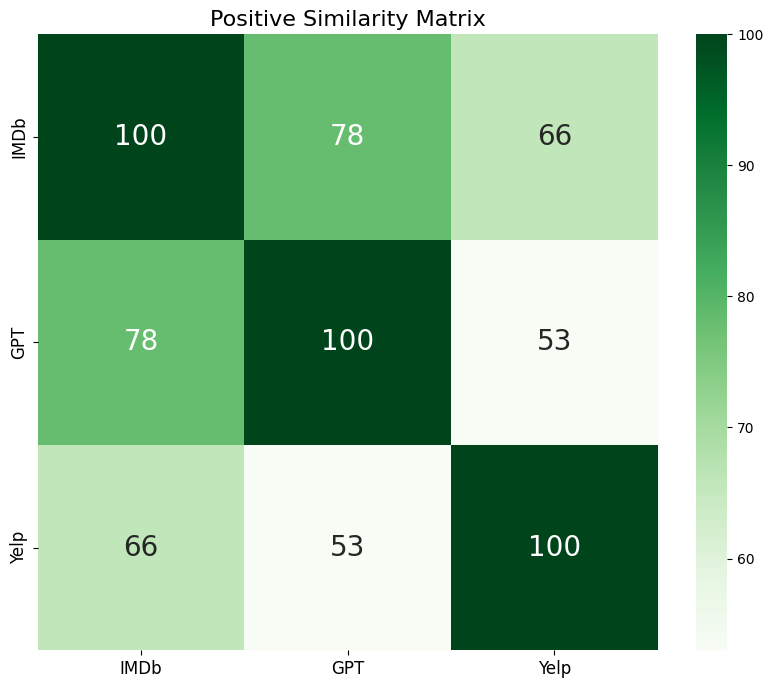

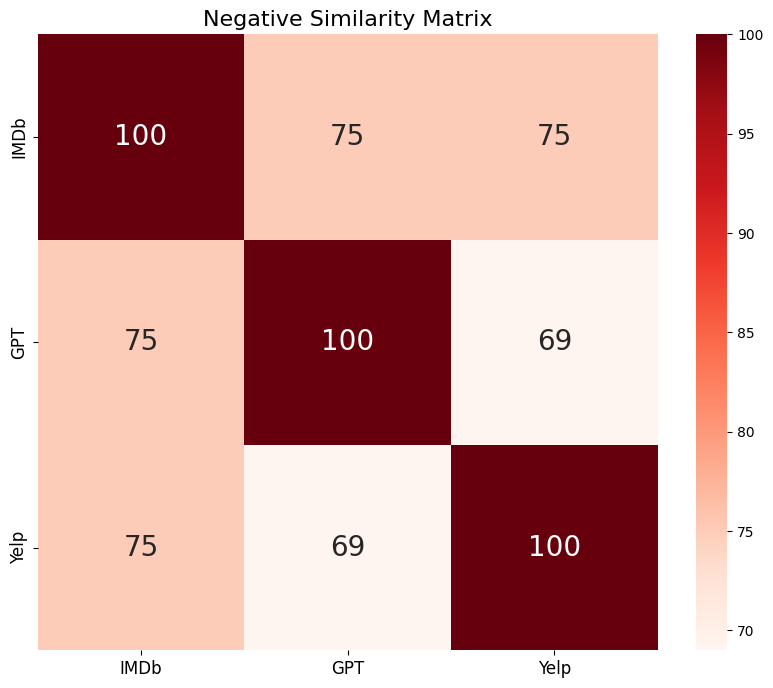

In [35]:
import matplotlib.pyplot as plt
# Dictionary of datasets
vector_dict = {
    1: "IMDb",
    2: "GPT",
    3: "Yelp",
}

# Initialize dictionaries to store positive and negative words for each dataset
positive_features = {}
negative_features = {}

# Load PosNeg_Vectors for each dataset
for key, dataset_name in vector_dict.items():
    # Load the dataset-specific vector
    data_path = f'../Data/{model_dict[Chosen_Model]["name"]}/{model_dict[Chosen_Model]["name"]}_PosNeg_Vectors.csv'
    PosNeg_Vectors = pd.read_csv(data_path)
    PosNeg_Vector = PosNeg_Vectors[PosNeg_Vectors['Dataset'] == dataset_name].iloc[:, 0:-1].reset_index(drop=True)

    # Project onto the chosen vector
    projected_variance, projection_in_1D_subspace = express_matrix_by_vector(matrix=word_embeddings, vector=PosNeg_Vector)

    # Find positive and negative words
    largest_indices = projection_in_1D_subspace.nlargest(100).index
    smallest_indices = projection_in_1D_subspace.nsmallest(100).index

    positive_features[dataset_name] = {review_tokens_corpus[i] for i in largest_indices}
    negative_features[dataset_name] = {review_tokens_corpus[i] for i in smallest_indices}

# Calculate positive and negative similarity matrices
positive_similarity_matrix = []
negative_similarity_matrix = []
dataset_names = list(vector_dict.values())
for dataset1 in dataset_names:
    positive_row = []
    negative_row = []
    for dataset2 in dataset_names:
        intersection_positive = len(positive_features[dataset1] & positive_features[dataset2])
        intersection_negative = len(negative_features[dataset1] & negative_features[dataset2])
        positive_row.append(intersection_positive)
        negative_row.append(intersection_negative)
    positive_similarity_matrix.append(positive_row)
    negative_similarity_matrix.append(negative_row)

# Convert to DataFrames for plotting
positive_similarity_df = pd.DataFrame(positive_similarity_matrix, index=dataset_names, columns=dataset_names)
negative_similarity_df = pd.DataFrame(negative_similarity_matrix, index=dataset_names, columns=dataset_names)

# Plot the positive similarity matrix
plt.figure(figsize=(10, 8))  # Increase the figure size for better readability
sns.heatmap(positive_similarity_df, annot=True, fmt="d", cmap="Greens", annot_kws={"size": 20})  # Increase annotation font size
plt.title("Positive Similarity Matrix", fontsize=16)  # Larger title font size
plt.xticks(fontsize=12)  # Larger x-axis labels
plt.yticks(fontsize=12)  # Larger y-axis labels
plt.show()

# Plot the negative similarity matrix
plt.figure(figsize=(10, 8))  # Increase the figure size for better readability
sns.heatmap(negative_similarity_df, annot=True, fmt="d", cmap="Reds", annot_kws={"size": 20})  # Increase annotation font size
plt.title("Negative Similarity Matrix", fontsize=16)  # Larger title font size
plt.xticks(fontsize=12)  # Larger x-axis labels
plt.yticks(fontsize=12)  # Larger y-axis labels
plt.show()
